<a href="https://colab.research.google.com/github/Taketo-Muroya/Nowcasting-Project/blob/main/Colab/nowcast-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The nowcasting of economic conditions in Japan using ML

2022/01/18　打ち合わせメモ

*   経済マクロデータを変数に含める（所得、エネルギー・食料・サービス価格、金利、インフレ期待、株価の先行き、感染者数）
*   見せかけの相関が疑われるので、(1,1,0)のARIMAが望ましいのでは。
*   コロナ前のデータとコロナ後で分ける見せ方、説明の仕方も良いかもしれない。

## Setting Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/Colab Notebooks/Economic-Nowcasting-in-Japan')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pytrends

In [3]:
# Import packages
import re
import os
import sys
import requests
#import MeCab
#import oseti
#import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from nltk.corpus import stopwords as sw       
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [5]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

## Target variable: Indexes of Business Conditions (IBC)

The Index of Business Conditions (IBC) represents monthly economic conditions in Japan. This study uses either coincident index (level) or coincident ann (change from the previouse year: Year-over-Year) as a target variable.

In [6]:
ibc = pd.read_csv('data/ibc_new.csv')
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)
ibc

,time,Coincident Index,Coincident ann
0,Jan-85,79.1,NaN
1,Feb-85,78.8,NaN
2,Mar-85,78.7,NaN
3,Apr-85,79.6,NaN
4,May-85,79.5,NaN
...,...,...,...
439,Aug-21,91.0,10.840438
440,Sep-21,88.7,4.722550
441,Oct-21,89.8,1.468927
442,Nov-21,92.8,4.740406


## Google Trend

Use google trend information as predictors

### Google Trend API

In [7]:
# Import packages
from pytrends.request import TrendReq
plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


Correlation of level: -0.87
Correlation of YoY: -0.77


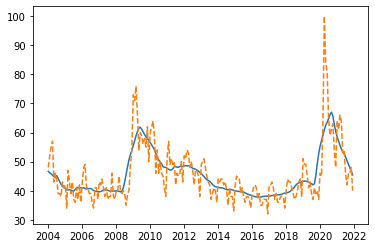

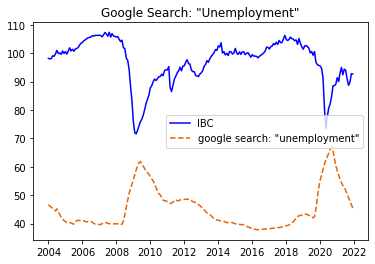

In [8]:
# Set keyword ("失業" = "unemployment")
kw1 = "失業"
kw_list1 = [kw1]
pytrends.build_payload(kw_list1, timeframe='2004-01-01 2021-12-31', geo='JP')
gt1 = pytrends.interest_over_time()
gt1 = gt1.rename(columns = {kw1:"var1", "isPartial":"info"})
#gt1.to_csv("data/gt1.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq')
t1 = s1.trend
#data1 = pd.merge(gt1.iloc[:,0], t1, on='date')
plt.plot(t1)
plt.plot(gt1.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1.index
cor = level.corr(t1)
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1.index
cor = ann.corr(a1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1.index, t1, linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend()
plt.title('Google Search: "Unemployment"')
plt.savefig("images/google1.png")

Correlation of level: 0.38
Correlation of YoY: 0.21


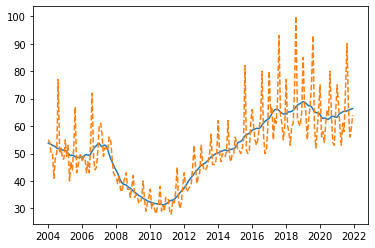

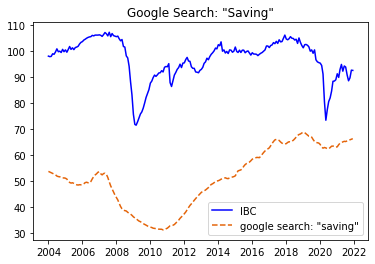

In [9]:
# Set keyword ("貯金" = "saving")
kw2 = "貯金"
kw_list2 = [kw2]
pytrends.build_payload(kw_list2, timeframe='2004-01-01 2021-12-31', geo='JP')
gt2 = pytrends.interest_over_time()
gt2 = gt2.rename(columns = {kw2:"var2", "isPartial":"info"})
#gt2.to_csv("data/gt2.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq')
t2 = s2.trend
plt.plot(t2)
plt.plot(gt2.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2.index
cor = level.corr(t2)
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2.index
cor = ann.corr(a2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2.index, t2, linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
plt.savefig("images/google2.png")

In [10]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1).rename(columns={'var1': 'var1_rate', 'var2': 'var2_rate'})
#gtrend_y = gtrend_y.drop(gtrend_y.index[0:12])

### Time series analysis

In [11]:
# Set time series dataset
X = pd.merge(gtrend_l, gtrend_y, on='date')
y = ibc[228:]
y = y.set_index('time')
y.index = X.index
ts = pd.merge(y, X, on='date')

# Split data into training and test set
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts

,Coincident Index,Coincident ann,var1,var2,var1_rate,var2_rate
date,,,,,,
2004-01-01,98.2,8.508287,46.629176,53.791618,NaN,NaN
2004-02-01,98.0,7.456140,46.189200,53.533168,NaN,NaN
2004-03-01,98.1,7.802198,45.749223,53.274718,NaN,NaN
2004-04-01,99.1,9.502762,45.309246,53.016268,NaN,NaN
2004-05-01,98.9,8.324206,44.869270,52.757819,NaN,NaN
...,...,...,...,...,...,...
2021-08-01,91.0,10.840438,50.347222,65.518697,-0.288136,0.125000
2021-09-01,88.7,4.722550,49.118056,65.739850,-0.245902,0.046875
2021-10-01,89.8,1.468927,47.888889,65.961004,-0.269841,0.037037


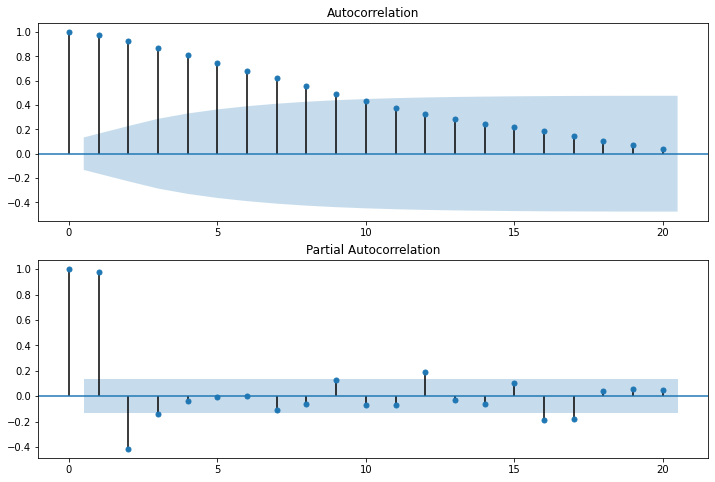

In [12]:
# Check Autocorrelation of IBC
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Coincident Index'], lags=20, ax=ax2)
plt.savefig("images/autocorrelation.png")

In [13]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['var1'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['var1'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var1'])
print("Cointegration test (var1): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var2'])
print("Cointegration test (var2): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.08
Unit root test (diff_y): 0.00
Unit root test (X): 0.09
Unit root test (diff_X): 0.03
Cointegration test (var1): 0.00
Cointegration test (var2): 0.29


### ARIMA Prediction

In [14]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,0), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  173
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -292.801
Date:                Fri, 11 Mar 2022   AIC                            593.601
Time:                        07:19:11   BIC                            606.191
Sample:                    01-01-2004   HQIC                           598.709
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1          -0.8736      0.165     -5.299      0.000      -1.197      -0.550
var2           0.1288      0.279      0.462      0.644      -0.418       0.675
ar.L1          0.1720      0.069      2.482      0.0

Test set score: 0.73


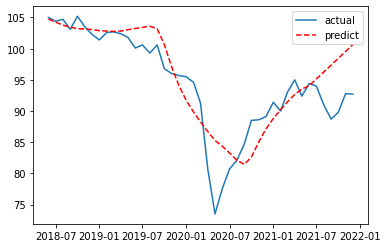

In [15]:
pred = SARIMAX.predict('2018-06-01', '2021-12-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.41
Test set score: 0.85


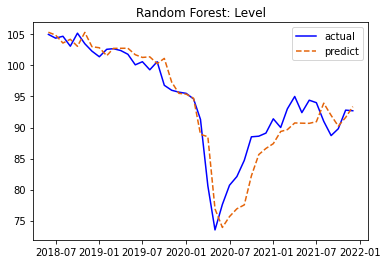

In [16]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_test.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(X_test.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/google_rf.png")

In [17]:
print(tm.feature_importances_)

[0.90395298 0.07206683 0.02398019]


### RNN-LSTM

In [18]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.tail()

,Coincident Index,var1,var2
date,,,
2021-08-01,91.0,50.347222,65.518697
2021-09-01,88.7,49.118056,65.739850
2021-10-01,89.8,47.888889,65.961004
2021-11-01,92.8,46.659722,66.182158
2021-12-01,92.7,45.430556,66.403312


In [19]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

173


In [20]:
# create the training and test data

past_history = 3
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [21]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,0.027224,0.464229,0.590842
1,0.000765,0.390416,0.565048
2,0.013994,0.316604,0.539255
3,0.146289,0.242791,0.513462
4,0.119830,0.168978,0.487668
5,0.238895,0.095165,0.461875
6,0.397648,0.218871,0.412038


In [22]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,0.027224,0.464229,0.590842
1,0.000765,0.390416,0.565048
2,0.013994,0.316604,0.539255
3,0.013994,0.242791,0.513462


In [23]:
y_train_single[0]

0.14628868576272533

In [24]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [25]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [26]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=30, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 9s 15ms/step - loss: 0.7326 - val_loss: 0.8144
Epoch 2/30
200/200 [==============================] - 2s 9ms/step - loss: 0.6127 - val_loss: 0.7992
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.5271 - val_loss: 0.7879
Epoch 4/30
200/200 [==============================] - 2s 8ms/step - loss: 0.4673 - val_loss: 0.7686
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.4211 - val_loss: 0.7413
Epoch 6/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3827 - val_loss: 0.7064
Epoch 7/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3506 - val_loss: 0.6688
Epoch 8/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3214 - val_loss: 0.6389
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2953 - val_loss: 0.6093
Epoch 10/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2708 - val_loss: 0.58

In [27]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.222786,0.472002,0.373627,0.780335


Test set score: 0.78


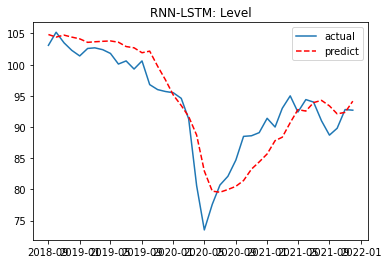

In [28]:
# visualize the result

predict = pd.DataFrame(single_step_model.predict(x_val_single)*data_std[0]+data_mean[0])
predict.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

actual = pd.DataFrame(y_val_single*data_std[0]+data_mean[0])
actual.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

plt.plot(features.iloc[TRAIN_SPLIT+past_history:,0], label="actual")
plt.plot(predict, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/google_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))


### Weekly Nowcasting

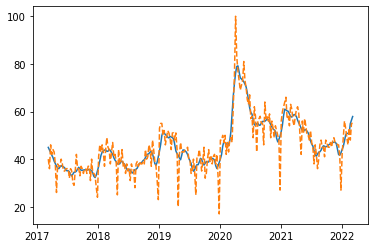

In [29]:
# Get the weekly google trend data (unemployment)
pytrends.build_payload(kw_list1, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2017-01-01 2021-01-16', geo='JP')
gt3 = pytrends.interest_over_time()
gt3 = gt3.rename(columns = {kw1: "var1", "isPartial": "info"})
#gt3.to_csv("data/gt3.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt3 = pd.read_csv('data/gt3.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s3 = seasonal_decompose(gt3.iloc[:,0], freq=6, extrapolate_trend='freq')
t3 = s3.trend
#gtw_u = pd.DataFrame(t3)
#gtw_u.to_csv("data/gtw_u.csv")

plt.plot(t3)
plt.plot(gt3.iloc[:,0], linestyle='--')

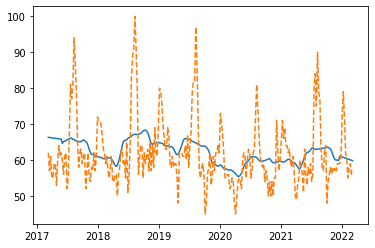

In [30]:
# Get the weekly google trend data (saving)
pytrends.build_payload(kw_list2, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
gt4 = pytrends.interest_over_time()
gt4 = gt4.rename(columns = {kw2: "var2", "isPartial": "info"})
#gt4.to_csv("data/gt4.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt4 = pd.read_csv('data/gt4.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s4 = seasonal_decompose(gt4.iloc[:,0], freq=24, extrapolate_trend='freq')
t4 = s4.trend
#gtw_s = pd.DataFrame(t4)
#gtw_s.to_csv("data/gtw_s.csv")

plt.plot(t4)
plt.plot(gt4.iloc[:,0], linestyle='--')

In [31]:
# load the weekly ibc data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
wibc = pd.read_csv('data/wibc.csv', index_col=0, date_parser=dateparse, dtype='float')

# merge google trend with ibc data
temp = pd.merge(t3, t4, on='date')
XX = pd.merge(wibc, temp, on='date')
XX

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,ibc,var1,var2
date,,,
2017-03-12,102.5,44.934921,66.308838
2017-03-19,102.5,43.823016,66.262968
2017-03-26,102.5,42.711111,66.217098
2017-04-02,103.4,41.666667,66.171229
2017-04-09,103.4,40.666667,66.125359
...,...,...,...
2022-01-30,NaN,50.916667,60.383705
2022-02-06,NaN,50.750000,60.270236
2022-02-13,NaN,50.833333,60.156766


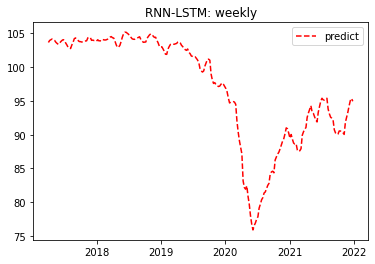

In [32]:
# feature scaling
END = len(XX)-XX['ibc'].isnull().sum()
dataset = XX.iloc[:END,:].values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

# create the test data
x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

# save the output
past_estimate = pd.DataFrame(single_step_model.predict(x_single)*data_std[0]+data_mean[0])
past_estimate.index = XX.iloc[past_history:END,:].index

# visualize the result 
plt.plot(past_estimate, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: weekly')
plt.savefig("images/google_lstm.png")


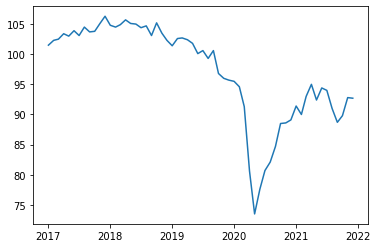

In [33]:
# compare to IBC graph
plt.plot(ts.iloc[156:,0:1])

In [34]:
# nowcast the future IBC
for i in range(END, len(XX)):
  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  #XX.iat[i,0] = XX.iat[i-1,0]
  temp = XX.iloc[:i+1,:]
  print(temp.tail())
  print('-----------------------------------------------')

  # feature scaling
  dataset = temp.values
  data_mean = dataset.mean(axis=0)
  data_std = dataset.std(axis=0)
  dataset = (dataset-data_mean)/data_std
  
  # create the test data
  x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  print(XX.tail(10))
  print('-----------------------------------------------')

# save the output
future_estimate = pd.DataFrame(XX.iloc[END:len(XX)+1,0])

                  ibc       var1       var2
date                                       
2021-12-05  92.700000  44.166667  59.979167
2021-12-12  92.700000  41.916667  59.833333
2021-12-19  92.700000  41.666667  61.064520
2021-12-26  92.700000  42.666667  60.951051
2022-01-02  94.945335  44.083333  60.837582
-----------------------------------------------
                  ibc       var1       var2
date                                       
2021-12-26  92.700000  42.666667  60.951051
2022-01-02  94.355362  44.083333  60.837582
2022-01-09        NaN  45.333333  60.724112
2022-01-16        NaN  47.583333  60.610643
2022-01-23        NaN  50.083333  60.497174
2022-01-30        NaN  50.916667  60.383705
2022-02-06        NaN  50.750000  60.270236
2022-02-13        NaN  50.833333  60.156766
2022-02-20        NaN  54.885714  60.043297
2022-02-27        NaN  56.388095  59.929828
-----------------------------------------------
                  ibc       var1       var2
date                    

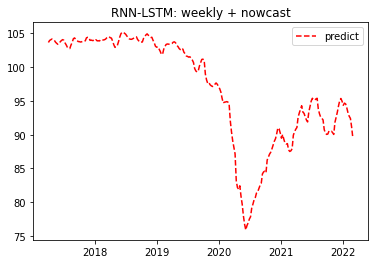

In [35]:
#plt.plot(single_step_model.predict(x_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")

df_concat = pd.concat([past_estimate.set_axis(['ibc'], axis='columns'), future_estimate])
plt.plot(df_concat, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: weekly + nowcast')
plt.savefig("images/google_lstm.png")

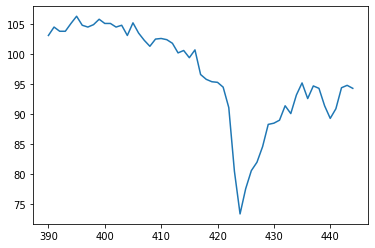

In [47]:
ibc_latest = pd.read_csv('data/ibc_latest.csv')
#ibc_latest

# compare to IBC graph
plt.plot(ibc_latest['Coincident Index'][390:])